In [5]:
from sklearn import preprocessing, pipeline
from sklearn import decomposition, cluster
from IPython.display import display
import numpy as np
import pandas as pd
import sqlite3 as sq
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import joblib as jb
from tqdm.auto import tqdm, trange
import os

In [6]:
%rm -rf encoders2/  
%rm -rf encoders2/  
%rm -rf encoders2/  
%rm -rf encoders2/  
%rm -rf encoders2/  

%rm -rf estimators/  
%rm -rf estimators2/
%rm -rf estimators3/
%rm -rf estimators4/
%rm -rf estimators5/

%rm cluster_centers1.csv
%rm cluster_centers2.csv
%rm cluster_centers3.csv
%rm cluster_centers.csv

%rm collision_counts.csv
%rm collision_counts1.csv
%rm collision_counts2.csv
%rm collision_counts3.csv



%rm cluster_counts.csv
%rm cluster_counts1.csv
%rm cluster_counts2.csv
%rm cluster_counts3.csv




rm: cannot remove 'cluster_centers1.csv': No such file or directory
rm: cannot remove 'cluster_centers2.csv': No such file or directory
rm: cannot remove 'cluster_centers3.csv': No such file or directory
rm: cannot remove 'cluster_centers.csv': No such file or directory
rm: cannot remove 'collision_counts.csv': No such file or directory
rm: cannot remove 'collision_counts1.csv': No such file or directory
rm: cannot remove 'collision_counts2.csv': No such file or directory
rm: cannot remove 'collision_counts3.csv': No such file or directory
rm: cannot remove 'cluster_counts.csv': No such file or directory
rm: cannot remove 'cluster_counts1.csv': No such file or directory
rm: cannot remove 'cluster_counts2.csv': No such file or directory
rm: cannot remove 'cluster_counts3.csv': No such file or directory


# Introduction

This notebook aims to clusterize motorcycles' collisions entries and confront them with motorcycle make information.

First `collisions` and `parties` tables are read excluding descriptive features.
Then they are preprocessed filling missing values and encoding categorical features.
Eventually different tables' information are merged together to build a single table.

# Data preprocessing

In [7]:
import sqlite3 as sql

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
con = sql.connect("/content/drive/MyDrive/switrs.sqlite/switrs.sqlite")
cur = con.cursor()

In [10]:
tables = [name[0] for name in cur.execute("SELECT name FROM sqlite_master")]
print("Tables:")
print(tables)

Tables:
['case_ids', 'collisions', 'victims', 'parties']


In [11]:
tables = ["collisions", "parties"]
print("Used tables: ")
print(tables)

Used tables: 
['collisions', 'parties']


In [12]:
cols = {table: list(map(lambda x: x[0], cur.execute("SELECT * FROM {}".format(table)).description)) for table in tables}
# print("Features of :")
for key,val in cols.items():
    print("Total features in "+ key +" table")
    display(val)
    print()

Total features in collisions table


['case_id',
 'jurisdiction',
 'officer_id',
 'reporting_district',
 'chp_shift',
 'population',
 'county_city_location',
 'county_location',
 'special_condition',
 'beat_type',
 'chp_beat_type',
 'city_division_lapd',
 'chp_beat_class',
 'beat_number',
 'primary_road',
 'secondary_road',
 'distance',
 'direction',
 'intersection',
 'weather_1',
 'weather_2',
 'state_highway_indicator',
 'caltrans_county',
 'caltrans_district',
 'state_route',
 'route_suffix',
 'postmile_prefix',
 'postmile',
 'location_type',
 'ramp_intersection',
 'side_of_highway',
 'tow_away',
 'collision_severity',
 'killed_victims',
 'injured_victims',
 'party_count',
 'primary_collision_factor',
 'pcf_violation_code',
 'pcf_violation_category',
 'pcf_violation',
 'pcf_violation_subsection',
 'hit_and_run',
 'type_of_collision',
 'motor_vehicle_involved_with',
 'pedestrian_action',
 'road_surface',
 'road_condition_1',
 'road_condition_2',
 'lighting',
 'control_device',
 'chp_road_type',
 'pedestrian_collision',



Total features in parties table


['id',
 'case_id',
 'party_number',
 'party_type',
 'at_fault',
 'party_sex',
 'party_age',
 'party_sobriety',
 'party_drug_physical',
 'direction_of_travel',
 'party_safety_equipment_1',
 'party_safety_equipment_2',
 'financial_responsibility',
 'hazardous_materials',
 'cellphone_in_use',
 'cellphone_use_type',
 'school_bus_related',
 'oaf_violation_code',
 'oaf_violation_category',
 'oaf_violation_section',
 'oaf_violation_suffix',
 'other_associate_factor_1',
 'other_associate_factor_2',
 'party_number_killed',
 'party_number_injured',
 'movement_preceding_collision',
 'vehicle_year',
 'vehicle_make',
 'statewide_vehicle_type',
 'chp_vehicle_type_towing',
 'chp_vehicle_type_towed',
 'party_race']

In [13]:
#Excluding the trivial features
cols = {
    "collisions":
    [
        "case_id",
        #"jurisdiction",
        #"officer_id",
        #"reporting_district",
        #"chp_shift",
        #"population",
        "county_city_location",
        #"county_location",
        "special_condition",
        "beat_type",
        "chp_beat_type",
        "city_division_lapd",
        "chp_beat_class",
        "beat_number",
        "primary_road",
        "secondary_road",
        "distance",
        "direction",
        "intersection",
        "weather_1",
        "weather_2",
        "state_highway_indicator",
        "caltrans_county",
        "caltrans_district",
        "state_route",
        "route_suffix",
        "postmile_prefix",
        "postmile",
        "location_type",
        "ramp_intersection",
        "side_of_highway",
        "tow_away",
        "collision_severity",
        "killed_victims",
        "injured_victims",
        "party_count",
        "primary_collision_factor",
        "pcf_violation_code",
        "pcf_violation_category",
        "pcf_violation",
        "pcf_violation_subsection",
        "hit_and_run",
        "type_of_collision",
        "motor_vehicle_involved_with",
        "pedestrian_action",
        "road_surface",
        "road_condition_1",
        "road_condition_2",
        "lighting",
        "control_device",
        "chp_road_type",
        "pedestrian_collision",
        "bicycle_collision",
        "motorcycle_collision",
        "truck_collision",
        "not_private_property",
        "alcohol_involved",
        "statewide_vehicle_type_at_fault",
        "chp_vehicle_type_at_fault",
        "severe_injury_count",
        "other_visible_injury_count",
        "complaint_of_pain_injury_count",
        "pedestrian_killed_count",
        "pedestrian_injured_count",
        "bicyclist_killed_count",
        "bicyclist_injured_count",
        "motorcyclist_killed_count",
        "motorcyclist_injured_count",
        "primary_ramp",
        "secondary_ramp",
        "latitude",
        "longitude",
        "collision_date",
        "collision_time",
        #"process_date"
    ],
    
    "parties":
    [
        #"id",
        "case_id",
        "party_number",
        "party_type",
        "at_fault",
        "party_sex",
        "party_age",
        "party_sobriety",
        "party_drug_physical",
        "direction_of_travel",
        "party_safety_equipment_1",
        "party_safety_equipment_2",
        "financial_responsibility",
        "hazardous_materials",
        #"cellphone_in_use",
        #"cellphone_use_type",
        "school_bus_related",
        "oaf_violation_code",
        "oaf_violation_category",
        "oaf_violation_section",
        "oaf_violation_suffix",
        "other_associate_factor_1",
        "other_associate_factor_2",
        "party_number_killed",
        "party_number_injured",
        "movement_preceding_collision",
        "vehicle_year",
        "vehicle_make",
        #"statewide_vehicle_type",
        #"chp_vehicle_type_towing",
        #"chp_vehicle_type_towed",
        "party_race"
    ]
}

for key,val in cols.items():
    print("Relevant features in " + key + " table")
    display(val)
    print()

Relevant features in collisions table


['case_id',
 'county_city_location',
 'special_condition',
 'beat_type',
 'chp_beat_type',
 'city_division_lapd',
 'chp_beat_class',
 'beat_number',
 'primary_road',
 'secondary_road',
 'distance',
 'direction',
 'intersection',
 'weather_1',
 'weather_2',
 'state_highway_indicator',
 'caltrans_county',
 'caltrans_district',
 'state_route',
 'route_suffix',
 'postmile_prefix',
 'postmile',
 'location_type',
 'ramp_intersection',
 'side_of_highway',
 'tow_away',
 'collision_severity',
 'killed_victims',
 'injured_victims',
 'party_count',
 'primary_collision_factor',
 'pcf_violation_code',
 'pcf_violation_category',
 'pcf_violation',
 'pcf_violation_subsection',
 'hit_and_run',
 'type_of_collision',
 'motor_vehicle_involved_with',
 'pedestrian_action',
 'road_surface',
 'road_condition_1',
 'road_condition_2',
 'lighting',
 'control_device',
 'chp_road_type',
 'pedestrian_collision',
 'bicycle_collision',
 'motorcycle_collision',
 'truck_collision',
 'not_private_property',
 'alcohol_in


Relevant features in parties table


['case_id',
 'party_number',
 'party_type',
 'at_fault',
 'party_sex',
 'party_age',
 'party_sobriety',
 'party_drug_physical',
 'direction_of_travel',
 'party_safety_equipment_1',
 'party_safety_equipment_2',
 'financial_responsibility',
 'hazardous_materials',
 'school_bus_related',
 'oaf_violation_code',
 'oaf_violation_category',
 'oaf_violation_section',
 'oaf_violation_suffix',
 'other_associate_factor_1',
 'other_associate_factor_2',
 'party_number_killed',
 'party_number_injured',
 'movement_preceding_collision',
 'vehicle_year',
 'vehicle_make',
 'party_race']

Now `collisions` table is read.

In [14]:
def convert_list(L):
    A = ""
    for x in L:
        A += x + ", "
    A = A[:-2]
    return A

df = {}

#Selecting records in collisions where a motorcycle was involved
motorcycle_collisions = "SELECT " + convert_list(cols["collisions"]) + " FROM collisions WHERE motorcycle_collision=1"
df["collisions"] = pd.DataFrame([list(x) for x in cur.execute(motorcycle_collisions)], columns=cols["collisions"])

print("Records in collisions table: {}".format(df["collisions"].shape[0]))
print("Features in collisions table: {}".format(df["collisions"].shape[1]))
display(df["collisions"].head())

Records in collisions table: 278684
Features in collisions table: 68


,case_id,county_city_location,special_condition,beat_type,chp_beat_type,city_division_lapd,chp_beat_class,beat_number,primary_road,secondary_road,distance,direction,intersection,weather_1,weather_2,state_highway_indicator,caltrans_county,caltrans_district,state_route,route_suffix,postmile_prefix,postmile,location_type,ramp_intersection,side_of_highway,tow_away,collision_severity,killed_victims,injured_victims,party_count,primary_collision_factor,pcf_violation_code,pcf_violation_category,pcf_violation,pcf_violation_subsection,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,road_condition_2,lighting,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,alcohol_involved,statewide_vehicle_type_at_fault,chp_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date,collision_time
0,3982906,1972,0,not chp,not chp,None,not chp,None,SEPULVEDA,HICKORY,0.0,None,1.0,clear,None,0.0,None,NaN,NaN,None,None,NaN,None,None,None,1.0,severe injury,0.0,1.0,2,vehicle code violation,None,automobile right of way,21801.0,A,not hit and run,broadside,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,functioning,0,0,0,1,0,1,1.0,passenger car,None,1,0,0,0,0,0,0,0,1,None,None,NaN,NaN,2009-01-12,17:10:00
1,3984246,3607,0,chp state highway,interstate,None,chp other,103,RT 10,4TH ST,51.0,south,0.0,clear,None,1.0,san bernardino,8.0,10.0,None,None,5.391,ramp,"ramp exit, last 50 feet",westbound,1.0,fatal,1.0,0.0,2,vehicle code violation,None,speeding,22350.0,None,not hit and run,hit object,fixed object,no pedestrian involved,dry,normal,None,daylight,functioning,1,0,0,1,0,1,NaN,motorcycle or scooter,motorcycle,0,0,0,0,0,0,0,1,0,TO,None,NaN,NaN,2009-01-11,13:02:00
2,3984329,2000,0,chp county roadline,county road line,None,chp other,044,COUNTY ROAD 145,RT 41,7392.0,east,0.0,cloudy,None,0.0,None,NaN,NaN,None,None,NaN,None,None,None,1.0,fatal,1.0,1.0,2,vehicle code violation,None,wrong side of road,21460.0,A,not hit and run,head-on,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,none,0,0,0,1,0,1,NaN,motorcycle or scooter,motorcycle,0,0,1,0,0,0,0,1,0,None,None,37.01290,-119.76988,2009-01-01,13:45:00
3,3984352,1942,0,not chp,not chp,None,not chp,6T7,HARVARD BL,3RD ST,0.0,None,1.0,clear,None,0.0,None,NaN,NaN,None,None,NaN,None,None,None,1.0,fatal,1.0,0.0,2,vehicle code violation,None,automobile right of way,21802.0,A,not hit and run,broadside,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,functioning,0,0,0,1,0,1,NaN,passenger car,"passenger car, station",0,0,0,0,0,0,0,1,0,None,None,NaN,NaN,2009-01-11,14:50:00
4,3984398,3400,0,chp county roadline,county road line,None,chp other,073,GERBER RD,COUNTRY PARK DR,85.0,west,0.0,clear,None,0.0,None,NaN,NaN,None,None,NaN,None,None,None,1.0,fatal,1.0,0.0,2,vehicle code violation,None,speeding,22350.0,None,not hit and run,broadside,other motor vehicle,no pedestrian involved,dry,normal,None,dusk or dawn,functioning,0,0,0,1,0,1,NaN,motorcycle or scooter,motorcycle,0,0,0,0,0,0,0,1,0,None,None,38.48171,-121.40174,2009-01-29,07:45:00


Timestamps are splitted in date and time and they are not parsed, so they are processed generating one column per field (i.s. year, month, day, hour, minute, second).
The columns to consider are `collision_date` and `collision_time`.

In [15]:
df["collisions"].loc[:, ["collision_date", "collision_time"]].isnull().sum()

collision_date      0
collision_time    770
dtype: int64

`collision_time` has some missing values.
Median value of timestamps distribution within the 24-hours day is used to fill missing values.

In [16]:
def get_seconds(hour, minute, second):
    return hour*3600 + minute*60 + second

def get_hms(seconds):
    hour = seconds // 3600
    seconds -= hour * 3600
    minute = seconds // 60
    seconds -= minute * 60
    second = round(seconds)
    return int(hour), int(minute), int(second)

def get_date_cols(col_date, col_time=None):
    
    year = col_date.apply(lambda x: pd.Timestamp(x).year)
    month = col_date.apply(lambda x: pd.Timestamp(x).month)
    day = col_date.apply(lambda x: pd.Timestamp(x).day)
    
    df = pd.DataFrame({"year": year.values, "month": month.values, "day": day.values}, index=col_date.index)
    
    if type(col_time) == pd.Series:
        
        # fill missing times with median
        time_median = col_time.apply(lambda x: get_seconds(*np.array(x.split(":")).astype(int)) if type(x)==str else np.nan).dropna().median()
        col_time = col_time.fillna(value="{:02d}:{:02d}:{:02d}".format(*get_hms(time_median)))

        hour = col_time.apply(lambda x: x.split(":")[0]).astype(int)
        minute = col_time.apply(lambda x: x.split(":")[1]).astype(int)
        second = col_time.apply(lambda x: x.split(":")[2]).astype(int)
        
        # pack time fields with date's
        df = df.join(pd.DataFrame({"hour": hour, "minute": minute, "second": second}, index=col_time.index))
    
    return df

df["collisions"] = df["collisions"].join(get_date_cols(df["collisions"].collision_date, df["collisions"].collision_time).rename(columns={var: "collision_date_"+var for var in ["year", "month", "day", "hour", "minute", "second"]}))
df["collisions"] = df["collisions"].drop(columns=["collision_date", "collision_time"])

df["collisions"].loc[:, ["collision_date_" + var for var in ["year", "month", "day", "hour", "minute", "second"]]].describe()

,collision_date_year,collision_date_month,collision_date_day,collision_date_hour,collision_date_minute,collision_date_second
count,278684.000000,278684.000000,278684.000000,278684.000000,278684.000000,278684.0
mean,2011.435009,6.657792,15.692106,13.841179,27.676067,0.0
std,5.716283,3.165702,8.775089,4.964365,17.467590,0.0
min,2001.000000,1.000000,1.000000,0.000000,0.000000,0.0
25%,2007.000000,4.000000,8.000000,11.000000,13.000000,0.0
50%,2012.000000,7.000000,16.000000,15.000000,30.000000,0.0
75%,2016.000000,9.000000,23.000000,17.000000,43.000000,0.0
max,2021.000000,12.000000,31.000000,23.000000,59.000000,0.0


Now missing values are filled using `"None"` label for categorical and $0$ for numeric features.
Maybe $0$ is not the best value to use but it does not belongs to other significant values of numeric columns.

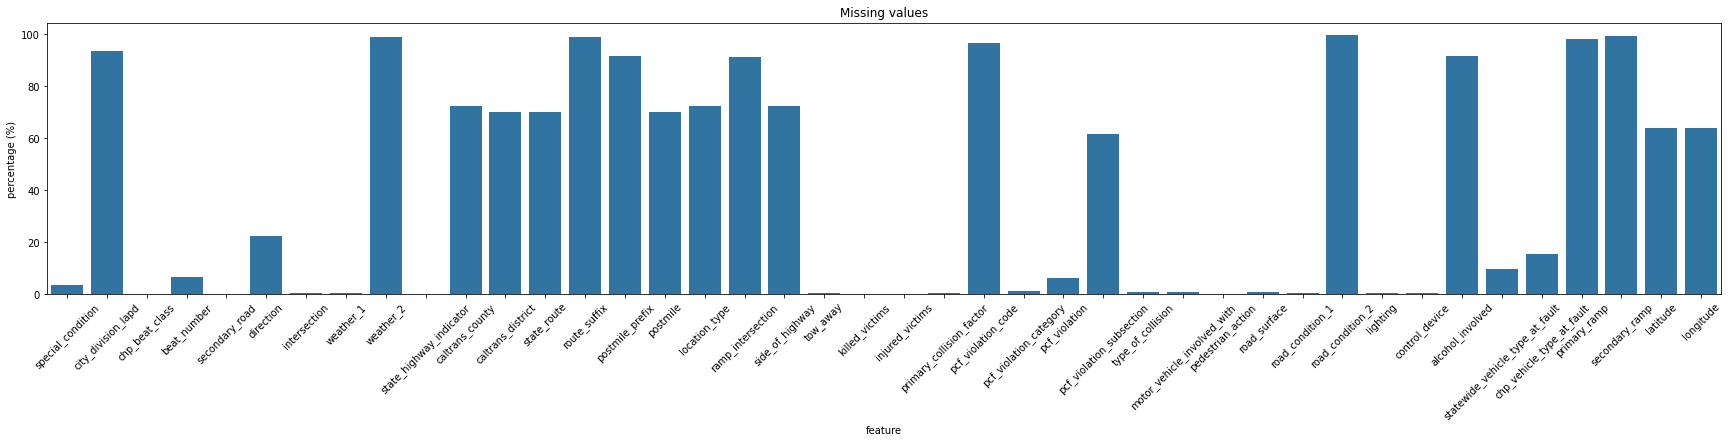

,intersection,state_highway_indicator,caltrans_district,state_route,postmile,tow_away,killed_victims,injured_victims,pcf_violation,alcohol_involved,latitude,longitude
count,276863.000000,278603.000000,83831.000000,83831.000000,83831.000000,277062.000000,278633.000000,278629.000000,260898.000000,23197.0,100605.000000,100605.000000
mean,0.212206,0.412605,6.421873,125.206368,18.627243,0.599721,0.033094,0.906061,22049.515581,1.0,35.468482,-119.306148
std,0.408871,0.492304,3.365053,187.451468,18.816228,0.489956,0.184336,0.581412,1482.981066,0.0,2.124129,1.990000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,32.500600,-124.450260
25%,0.000000,0.000000,4.000000,10.000000,4.960000,0.000000,0.000000,1.000000,21801.000000,1.0,33.887930,-121.364490
50%,0.000000,0.000000,7.000000,75.000000,13.950000,1.000000,0.000000,1.000000,22107.000000,1.0,34.232680,-118.414500
75%,0.000000,1.000000,8.000000,110.000000,26.250000,1.000000,0.000000,1.000000,22350.000000,1.0,37.598920,-117.732540
max,1.000000,1.000000,12.000000,980.000000,406.580000,1.000000,5.000000,27.000000,38506.000000,1.0,42.001660,-114.107620


In [17]:
def preprocess_missing(df, figsize=(30,5), none_is_na = True):
    
    ''' Fill missing values: with "None" for labels, with 0 for numeric features '''
    
    df = df.copy()
    
    if none_is_na:
        df = df.replace("None", np.nan)
    
    null_counts = (df.isnull().sum() / df.shape[0] * 100).loc[lambda x: x!=0]
    
    fig,ax = plt.subplots(figsize=figsize)
    ax = sns.barplot(x=null_counts.index, y=null_counts.values, color="C0", ax=ax)
    ax.tick_params(axis="x", rotation=45)
    ax.set_title("Missing values")
    ax.set_xlabel("feature")
    ax.set_ylabel("percentage (%)")
    plt.show()
    
    drop_cols = null_counts.loc[lambda x: x==100].index.tolist()
    df = df.drop(columns=drop_cols)
    if len(drop_cols) != 0:
        print("Completely null features:")
        for col in drop_cols:
            print("\t"+col)
    
    null_obj = df.dtypes.loc[null_counts.index].loc[lambda x: x==object]
    null_numeric = df.dtypes.loc[null_counts.index].loc[lambda x: x!=object]
    
    df.loc[:,null_obj.index] = df.loc[:,null_obj.index].fillna(value="None")
    
    display(df.loc[:,null_numeric.index].describe())
    
    # all numeric features with missing values can be filled with 0 in all tables, because of this the following line of code is commented
    #fill_numeric = input("Fill missing numeric values with 0? (Y/n): ")
    fill_numeric = "y"
    
    if fill_numeric in ["Y", "y", ""]:
        df.loc[:, null_numeric.index] = df.loc[:, null_numeric.index].fillna(value=0)
        
    return df

df["collisions"] = preprocess_missing(df["collisions"])

In [18]:
# get collisions' parties on a motorcycle (or scooter)
motorcycle_collisions = "SELECT " + convert_list(cols["parties"]) + " FROM parties "
motorcycle_collisions += "WHERE case_id IN (" + convert_list(df["collisions"].case_id) + ") AND statewide_vehicle_type = 'motorcycle or scooter'"
df["parties"] = pd.DataFrame([list(x) for x in cur.execute(motorcycle_collisions)], columns=cols["parties"])

display(df["parties"].head())
print("\nEntries: {}".format(df["parties"].shape[0]))
print("Features: {}".format(df["parties"].shape[1]))

,case_id,party_number,party_type,at_fault,party_sex,party_age,party_sobriety,party_drug_physical,direction_of_travel,party_safety_equipment_1,party_safety_equipment_2,financial_responsibility,hazardous_materials,school_bus_related,oaf_violation_code,oaf_violation_category,oaf_violation_section,oaf_violation_suffix,other_associate_factor_1,other_associate_factor_2,party_number_killed,party_number_injured,movement_preceding_collision,vehicle_year,vehicle_make,party_race
0,3982906,2,driver,0,male,25.0,impairment unknown,G,west,"driver, motorcycle helmet used",None,proof of insurance obtained,NaN,NaN,None,None,None,None,None,None,0,1,proceeding straight,2008.0,kawasaki,white
1,3984246,1,driver,1,male,28.0,None,under drug influence,east,not required,"driver, motorcycle helmet used",no proof of insurance obtained,NaN,NaN,None,None,None,None,none apparent,None,1,0,proceeding straight,2005.0,suzuki,other
2,3984329,1,driver,1,female,38.0,had not been drinking,under drug influence,east,not required,"driver, motorcycle helmet used",proof of insurance obtained,NaN,NaN,None,wrong side of road,21650,None,violation,None,1,0,crossed into opposing lane,2006.0,suzuki,white
3,3984352,2,driver,0,male,21.0,had not been drinking,under drug influence,west,air bag deployed,"driver, motorcycle helmet used",None,NaN,NaN,None,None,None,None,none apparent,None,1,0,proceeding straight,2007.0,ducati,white
4,3984398,1,driver,1,male,20.0,had not been drinking,None,west,not required,"driver, motorcycle helmet used",None,NaN,NaN,None,None,None,None,none apparent,None,1,0,proceeding straight,2003.0,honda,black



Entries: 260795
Features: 26


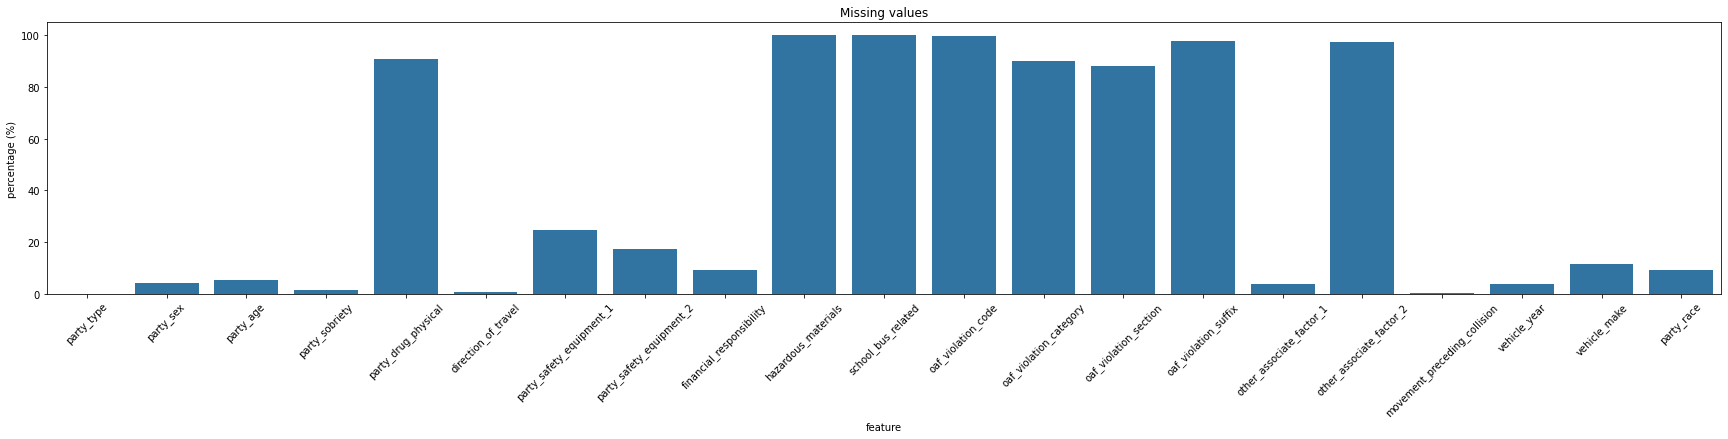

,party_age,hazardous_materials,school_bus_related,vehicle_year
count,246234.000000,223.0,288.0,250193.000000
mean,37.338905,1.0,1.0,2004.461556
std,14.208053,0.0,0.0,8.850637
min,0.000000,1.0,1.0,1016.000000
25%,25.000000,1.0,1.0,2001.000000
50%,34.000000,1.0,1.0,2005.000000
75%,48.000000,1.0,1.0,2009.000000
max,104.000000,1.0,1.0,2075.000000


In [19]:
df["parties"] = preprocess_missing(df["parties"])

In [20]:
print("Motorcycles without make: {}".format((df["parties"].vehicle_make == "None").sum()))

Motorcycles without make: 29830


Motorcycles without a make are not useful so they are removed.

In [21]:
df["parties"] = df["parties"].loc[df["parties"].vehicle_make != "None"]

Collisions data are merged into `parties` table using case ids.
Moreover, in this way collisions without any party entry will be excluded.

In [22]:
df = df["parties"].merge(df["collisions"], on="case_id", how="left").set_index(["case_id", "party_number"]).sort_index()
print("Dataset shape: {}".format(df.shape))

Dataset shape: (230965, 95)


Now categorical features are encoded.

In [23]:
def encode_labels(df, progress=True):
    df = df.copy()
    label_encoders = {}
    for col in tqdm(df.dtypes.loc[lambda x: x==object].index, disable=not progress):
        label_encoders[col] = preprocessing.LabelEncoder().fit(df.loc[:,col])
        df.loc[:,col] = label_encoders[col].transform(df.loc[:,col])
    return df, label_encoders

df_enc, label_encoders = encode_labels(df)

  0%|          | 0/54 [00:00<?, ?it/s]

In [24]:
targets = ["vehicle_make"]
x,y = df_enc.drop(columns=targets), df_enc.loc[:,targets]

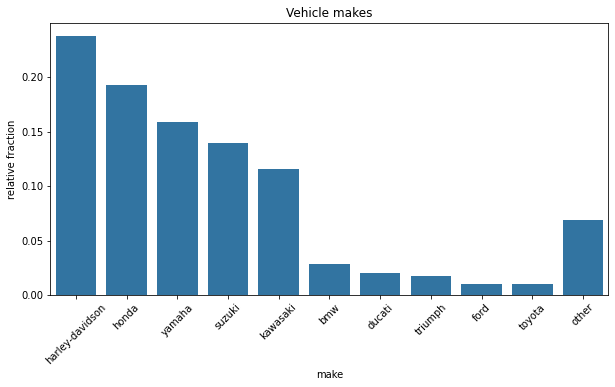

In [25]:
N = 10 # how many makes to show separately
vehicle_make_frac = (df.vehicle_make.value_counts() / df.shape[0]).sort_values(ascending=False).iloc[:N]
vehicle_make_frac = vehicle_make_frac.append(pd.Series([1 - vehicle_make_frac.sum()], index=["other"]))

fig,ax = plt.subplots(figsize=(10,5))
ax.set_title("Vehicle makes")
ax.set_ylabel("relative fraction")
ax.set_xlabel("make")
ax.tick_params(axis="x", rotation=45)
ax = sns.barplot(x=vehicle_make_frac.index, y=vehicle_make_frac.values, color="C0", ax=ax)

del vehicle_make_frac


# Principal Component Analysis

PCA could be used to reduce the dimensionality of the data.
This is possible only if a restricted number of the first principal components contain a sufficient amount of the original variance.

In [ ]:
def get_pca_pipe(x):
    ''' Fit PCA and return model '''
    pca_pipe = pipeline.Pipeline([
        ("scaler", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA(random_state=1))
    ])
    pca_pipe = pca_pipe.fit(x)
    return pca_pipe

pca_pipe = get_pca_pipe(x)
pca = pca_pipe.named_steps["pca"]

ax = sns.lineplot(x=np.arange(1,pca.n_components_+1), y=pca.explained_variance_ratio_.cumsum())
ax.set_title("Train set PCA")
ax.set_xlabel("principal components")
_ = ax.set_ylabel("cum. explained var. ratio")

First principal components do not contain much of the original variance to be representative of the starting space, so PCA results are not used.

In [ ]:
# # get collisions' parties on a motorcycle (or scooter)
# cmd = "SELECT " + convert_list(cols["parties"]) + " FROM parties "
# cmd += "WHERE case_id IN (" + convert_list(df["collisions"].case_id) + ") AND statewide_vehicle_type = 'motorcycle or scooter'"
# df["parties"] = pd.DataFrame([list(x) for x in cur.execute(cmd)], columns=cols["parties"])

# display(df["parties"].head())
# print("\nEntries: {}".format(df["parties"].shape[0]))
# print("Features: {}".format(df["parties"].shape[1]))
# df["parties"] = preprocess_missing(df["parties"])
# print("Motorcycles without make: {}".format((df["parties"].vehicle_make == "None").sum()))
# df["parties"] = df["parties"].loc[df["parties"].vehicle_make != "None"]
# df = df["parties"].merge(df["collisions"], on="case_id", how="left").set_index(["case_id", "party_number"]).sort_index()
# print("Dataset shape: {}".format(df.shape))
# def encode_labels(df, progress=True):
#     df = df.copy()
#     label_encoders = {}
#     for col in tqdm(df.dtypes.loc[lambda x: x==object].index, disable=not progress):
#         label_encoders[col] = preprocessing.LabelEncoder().fit(df.loc[:,col])
#         df.loc[:,col] = label_encoders[col].transform(df.loc[:,col])
#     return df, label_encoders

# df_enc, label_encoders = encode_labels(df)
# targets = ["vehicle_make"]
# x,y = df_enc.drop(columns=targets), df_enc.loc[:,targets]

# Clustering Algorithms

Before introducing clusters in data, their inertia is studied varying the groups number used by estimator.
Then clusters are produced using a value near the elbow of the resulting inertia plot.

### Mini Batch KMeans

In [ ]:
MiniBatchKmeans_train = x.copy()
MiniBatchKMeans_target = y.copy()
MiniBatchKMeans_df= df.copy()
MiniBatchKMeans_df_enc = df_enc.copy()

In [ ]:
def get_MiniBatchKMeans_pipe(x, n, batch_size=1000):
    cluster_pipe = pipeline.Pipeline([
        ("scaler", preprocessing.StandardScaler()),
        ("cluster", cluster.MiniBatchKMeans(n_clusters=n, batch_size=batch_size, random_state=1))
    ])
    cluster_pipe = cluster_pipe.fit(x)
    return cluster_pipe

N = 150 # maximum clusters tested
inertia = [cluster_pipe.named_steps["cluster"].inertia_ for cluster_pipe in jb.Parallel(n_jobs=-1)(jb.delayed(get_MiniBatchKMeans_pipe)(MiniBatchKmeans_train, n) for n in trange(2,N+1))]

ax = sns.lineplot(x=np.arange(2,N+1), y=inertia)
ax.set_title("Choosing the no. of clusters")
ax.set_xlabel("No. of Clusters")
_ = ax.set_ylabel("Inertia")

From the above graph, we can select the inflection point as $60$ for deciding the number pf clusters.

In [ ]:
# MiniBatchKmeans_train.drop('cluster', axis=1, inplace=True)
# MiniBatchKMeans_df.drop('cluster', axis=1, inplace=True)
# MiniBatchKMeans_df_enc.drop('cluster', axis=1, inplace=True)

In [ ]:
cluster_pipe = get_MiniBatchKMeans_pipe(MiniBatchKmeans_train, n=60)
cluster_values = cluster_pipe.predict(MiniBatchKmeans_train)
MiniBatchKmeans_train.insert(loc=MiniBatchKmeans_train.shape[1], column="cluster", value=cluster_values)
MiniBatchKMeans_df.insert(loc=MiniBatchKMeans_df.shape[1], column="cluster", value=cluster_values)
MiniBatchKMeans_df_enc.insert(loc=MiniBatchKMeans_df_enc.shape[1], column="cluster", value=cluster_values)

Clusters' properties can be retrieved form their centers.

In [ ]:
def decode_labels(df, encoders, progress=False):
    df = df.copy()
    for col in encoders.keys():
        if col in df.columns:
            df.loc[:,col] = encoders[col].inverse_transform(df.loc[:,col].apply(lambda x: round(x))) # decode with the nearest valid label
    return df

# cluster characteristics
cluster_centers = pd.DataFrame(cluster_pipe.named_steps["scaler"].inverse_transform(cluster_pipe.named_steps["cluster"].cluster_centers_), columns=MiniBatchKmeans_train.drop(columns="cluster").columns)
cluster_centers.index.name = "cluster"
cluster_centers = decode_labels(cluster_centers, label_encoders)
cluster_centers.head()

Since clustering did not take into account `vehicle_make`, motorcycles could belong to one or more clusters based on collisions characteristics.
Because of this next table shows the number of clusters that can be counted counted for each make.

In [ ]:
# clusters counts per vehicle make
cluster_counts = pd.DataFrame({"clusters": MiniBatchKMeans_df.groupby("vehicle_make").cluster.nunique()})
cluster_counts = cluster_counts.sort_index().sort_values("clusters", ascending=False)
cluster_counts.head()

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set_title("Makes' clusters")
ax.set_xlabel("Make's number of clusters")
ax.set_ylabel("relative fraction")
ax = sns.histplot(data=cluster_counts, x="clusters", stat="probability", bins=np.arange(1,cluster_pipe.named_steps["cluster"].cluster_centers_.shape[0] + 2) - 0.5, ax=ax)

Approximately $58\%$ of makes has collisions belonging only to one cluster.
This means that those motorcycles made incidents with approximately the same characteristics, attributable to a single group.

In [ ]:
# (vehicle_make, cluster) collisions counts
collision_counts = pd.DataFrame({"collisions": MiniBatchKMeans_df.loc[:, ["vehicle_make", "cluster"]].value_counts()})
collision_counts = collision_counts.sort_values("collisions", ascending=False)
collision_counts.head()

In **Data preprocessing** section an histogram showing the relative fraction of collisions per make is already present.
Now the following plot shows the relative fraction of collisions per cluster.

In [ ]:
collision_counts_cluster = collision_counts.groupby("cluster").collisions.sum() / collision_counts.collisions.sum()

fig,ax = plt.subplots(figsize=(15,5))
ax.set_title("Clusters collisions")
ax.set_xlabel("cluster")
ax.set_ylabel("relative fraction")
ax = sns.barplot(x=collision_counts_cluster.index, y=collision_counts_cluster.values, ax=ax, color="C0")

Now final results are saved.

In [ ]:
encoders_dir = "MiniBatchKMeans_encoders"
os.mkdir(encoders_dir)
for col in label_encoders.keys():
    jb.dump(label_encoders[col], encoders_dir + "/" + col + ".pkl")

estimators_dir = "MiniBatchKMeans_estimators"
os.mkdir(estimators_dir)
jb.dump(cluster_pipe, estimators_dir + "/MiniBatchKMeans_cluster_pipe.pkl")

cluster_centers.to_csv("MiniBatchKMeans_cluster_centers.csv")
cluster_counts.to_csv("MiniBatchKMeans_cluster_counts.csv")
collision_counts.to_csv("MiniBatchKMeans_collision_counts.csv")

### KMeans 

In [ ]:
Kmeans_train = x.copy()
KMeans_target = y.copy()
KMeans_df= df.copy()
KMeans_df_enc = df_enc.copy()

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50)
svd.fit(Kmeans_train)
Kmeans_train_svd = svd.transform(Kmeans_train)

In [ ]:
from sklearn.cluster import KMeans
def get_Kmeans_pipe(x, n):
    cluster_pipe = pipeline.Pipeline([
        ("scaler", preprocessing.StandardScaler()),
        ("cluster", cluster.KMeans(n_clusters=n, random_state=1))
    ])
    cluster_pipe = cluster_pipe.fit(x)
    return cluster_pipe

# N = 150 # maximum clusters tested
# inertia = [cluster_pipe.named_steps["cluster"].inertia_ for cluster_pipe in jb.Parallel(n_jobs=-1)(jb.delayed(get_Kmeans_pipe)(Kmeans_train_svd, n) for n in trange(2,N+1))]

# ax = sns.lineplot(x=np.arange(2,N+1), y=inertia)
# ax.set_title("Train set clustering inertia")
# ax.set_xlabel("n_clusters")
# _ = ax.set_ylabel("inertia")

In [ ]:
cluster_pipe = get_Kmeans_pipe(Kmeans_train_svd, n=60)
cluster_values = cluster_pipe.predict(Kmeans_train_svd)

In [ ]:
# Kmeans_train.drop('cluster', axis=1, inplace=True)
# KMeans_df.drop('cluster', axis=1, inplace=True)
# KMeans_df_enc.drop('cluster', axis=1, inplace=True)

In [ ]:
Kmeans_train.insert(loc=Kmeans_train.shape[1], column="cluster", value=cluster_values)
KMeans_df.insert(loc=KMeans_df.shape[1], column="cluster", value=cluster_values)
KMeans_df_enc.insert(loc=KMeans_df_enc.shape[1], column="cluster", value=cluster_values)

In [ ]:
def decode_labels(df, encoders, progress=False):
    df = df.copy()
    for col in encoders.keys():
        if col in df.columns:
            df.loc[:,col] = encoders[col].inverse_transform(df.loc[:,col].apply(lambda x: round(x))) # decode with the nearest valid label
    return df

# cluster characteristics
#cluster_centers = pd.DataFrame(cluster_pipe.named_steps["scaler"].inverse_transform(cluster_pipe.named_steps["cluster"].cluster_centers_), columns=x2.drop(columns="cluster").columns)
#cluster_centers.index.name = "cluster"
cluster_centers = decode_labels(Kmeans_train.drop(columns="cluster"), label_encoders)
cluster_centers.head()

In [ ]:
# clusters counts per vehicle make
cluster_counts = pd.DataFrame({"clusters": KMeans_df.groupby("vehicle_make").cluster.nunique()})
cluster_counts = cluster_counts.sort_index().sort_values("clusters", ascending=False)
cluster_counts.head()

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set_title("Makes' clusters")
ax.set_xlabel("Make's number of clusters")
ax.set_ylabel("relative fraction")
ax = sns.histplot(data=cluster_counts, x="clusters", stat="probability", bins=np.arange(1,cluster_pipe.named_steps["cluster"].cluster_centers_.shape[0] + 2) - 0.5, ax=ax)

In [ ]:
# (vehicle_make, cluster) collisions counts
collision_counts = pd.DataFrame({"collisions": KMeans_df.loc[:, ["vehicle_make", "cluster"]].value_counts()})
collision_counts = collision_counts.sort_values("collisions", ascending=False)
collision_counts.head()

In [ ]:
collision_counts_cluster = collision_counts.groupby("cluster").collisions.sum() / collision_counts.collisions.sum()

fig,ax = plt.subplots(figsize=(15,5))
ax.set_title("Clusters collisions")
ax.set_xlabel("cluster")
ax.set_ylabel("relative fraction")
ax = sns.barplot(x=collision_counts_cluster.index, y=collision_counts_cluster.values, ax=ax, color="C0")

In [ ]:
encoders_dir = "KMeans_encoders"
os.mkdir(encoders_dir)
for col in label_encoders.keys():
    jb.dump(label_encoders[col], encoders_dir + "/" + col + ".pkl")

estimators_dir = "KMeans_estimators"
os.mkdir(estimators_dir)
jb.dump(cluster_pipe, estimators_dir + "/KMeans_cluster_pipe.pkl")

cluster_centers.to_csv("KMeans_cluster_centers.csv")
cluster_counts.to_csv("KMeans_cluster_counts.csv")
collision_counts.to_csv("KMeans_collision_counts.csv")

### OPTICS

In [26]:
x3 = x.copy()
y3 = y.copy()
df3= df.copy()
df_enc3 = df_enc.copy()

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50)
svd.fit(x3)
x3_svd = svd.transform(x3)

In [ ]:
from sklearn.cluster import OPTICS
# define the model
optics_model = OPTICS(eps=0.2, min_samples=9)

# train the model
optics_result = optics_model.fit_predict(x3_svd)

In [ ]:
x3.drop('cluster', axis=1, inplace=True)
df3.drop('cluster', axis=1, inplace=True)
df_enc3.drop('cluster', axis=1, inplace=True)

In [ ]:
x3.insert(loc=x3.shape[1], column="cluster", value=optics_result)
df3.insert(loc=df3.shape[1], column="cluster", value=optics_result)
df_enc3.insert(loc=df_enc3.shape[1], column="cluster", value=optics_result)

In [ ]:
def decode_labels(df, encoders, progress=False):
    df = df.copy()
    for col in encoders.keys():
        if col in df.columns:
            df.loc[:,col] = encoders[col].inverse_transform(df.loc[:,col].apply(lambda x: round(x))) # decode with the nearest valid label
    return df

# cluster characteristics
#cluster_centers = pd.DataFrame(cluster_pipe.named_steps["scaler"].inverse_transform(cluster_pipe.named_steps["cluster"].cluster_centers_), columns=x2.drop(columns="cluster").columns)
#cluster_centers.index.name = "cluster"
cluster_centers = decode_labels(x3.drop(columns="cluster"), label_encoders)
cluster_centers.head()

In [ ]:
# clusters counts per vehicle make
cluster_counts = pd.DataFrame({"clusters": df3.groupby("vehicle_make").cluster.nunique()})
cluster_counts = cluster_counts.sort_index().sort_values("clusters", ascending=False)
cluster_counts.head()

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set_title("Makes' clusters")
ax.set_xlabel("Make's number of clusters")
ax.set_ylabel("relative fraction")
ax = sns.histplot(data=cluster_counts, x="clusters", stat="probability", bins=np.arange(1,cluster_pipe.named_steps["cluster"].cluster_centers_.shape[0] + 2) - 0.5, ax=ax)

In [ ]:
# (vehicle_make, cluster) collisions counts
collision_counts = pd.DataFrame({"collisions": df3.loc[:, ["vehicle_make", "cluster"]].value_counts()})
collision_counts = collision_counts.sort_values("collisions", ascending=False)
collision_counts.head()

In [ ]:
collision_counts_cluster = collision_counts.groupby("cluster").collisions.sum() / collision_counts.collisions.sum()

fig,ax = plt.subplots(figsize=(15,5))
ax.set_title("Clusters collisions")
ax.set_xlabel("cluster")
ax.set_ylabel("relative fraction")
ax = sns.barplot(x=collision_counts_cluster.index, y=collision_counts_cluster.values, ax=ax, color="C0")

In [ ]:
encoders_dir = "encoders3"
os.mkdir(encoders_dir)
for col in label_encoders.keys():
    jb.dump(label_encoders[col], encoders_dir + "/" + col + ".pkl")

estimators_dir = "estimators3"
os.mkdir(estimators_dir)
jb.dump(optics_model, estimators_dir + "/cluster_pipe3.pkl")

cluster_centers.to_csv("cluster_centers3.csv")
cluster_counts.to_csv("cluster_counts3.csv")
collision_counts.to_csv("collision_counts3.csv")

### BIRCH

In [ ]:
x4 = x.iloc[0:9999,:]
y4 = y.iloc[0:9999,:]
df4= df.iloc[0:9999,:]
df_enc4 = df_enc.iloc[0:9999,:]


BIRCH_train = x.copy()
BIRCH_target = y.copy()
BIRCH_df= df.copy()
BIRCH_df_enc = df_enc.copy()


from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50)
svd.fit(BIRCH_train)
BIRCH_train_svd = svd.transform(BIRCH_train)

In [ ]:
from sklearn.cluster import Birch
# define the model
birch_model = Birch(threshold=0.03, n_clusters=60)

# train the model
birch_result = birch_model.fit_predict(BIRCH_train_svd)

In [ ]:
# BIRCH_train.drop('cluster', axis=1, inplace=True)
# BIRCH_df.drop('cluster', axis=1, inplace=True)
# BIRCH_df_enc.drop('cluster', axis=1, inplace=True)

In [ ]:
BIRCH_train.insert(loc=BIRCH_train.shape[1], column="cluster", value=birch_result)
BIRCH_df.insert(loc=BIRCH_df.shape[1], column="cluster", value=birch_result)
BIRCH_df_enc.insert(loc=BIRCH_df_enc.shape[1], column="cluster", value=birch_result)

In [ ]:
def decode_labels(df, encoders, progress=False):
    df = df.copy()
    for col in encoders.keys():
        if col in df.columns:
            df.loc[:,col] = encoders[col].inverse_transform(df.loc[:,col].apply(lambda x: round(x))) # decode with the nearest valid label
    return df

# cluster characteristics
#cluster_centers = pd.DataFrame(cluster_pipe.named_steps["scaler"].inverse_transform(cluster_pipe.named_steps["cluster"].cluster_centers_), columns=x2.drop(columns="cluster").columns)
#cluster_centers.index.name = "cluster"
cluster_centers = decode_labels(BIRCH_train.drop(columns="cluster"), label_encoders)
cluster_centers.head()

In [ ]:
# clusters counts per vehicle make
cluster_counts = pd.DataFrame({"clusters": BIRCH_df.groupby("vehicle_make").cluster.nunique()})
cluster_counts = cluster_counts.sort_index().sort_values("clusters", ascending=False)
cluster_counts.head()

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set_title("Makes' clusters")
ax.set_xlabel("Make's number of clusters")
ax.set_ylabel("relative fraction")
ax = sns.histplot(data=cluster_counts, x="clusters", stat="probability", bins=np.arange(1,cluster_pipe.named_steps["cluster"].cluster_centers_.shape[0] + 2) - 0.5, ax=ax)

In [ ]:
# (vehicle_make, cluster) collisions counts
collision_counts = pd.DataFrame({"collisions": BIRCH_df.loc[:, ["vehicle_make", "cluster"]].value_counts()})
collision_counts = collision_counts.sort_values("collisions", ascending=False)
collision_counts.head()

In [ ]:
collision_counts_cluster = collision_counts.groupby("cluster").collisions.sum() / collision_counts.collisions.sum()

fig,ax = plt.subplots(figsize=(15,5))
ax.set_title("Clusters collisions")
ax.set_xlabel("cluster")
ax.set_ylabel("relative fraction")
ax = sns.barplot(x=collision_counts_cluster.index, y=collision_counts_cluster.values, ax=ax, color="C0")

In [ ]:
encoders_dir = "BIRCH_encoders"
os.mkdir(encoders_dir)
for col in label_encoders.keys():
    jb.dump(label_encoders[col], encoders_dir + "/" + col + ".pkl")

estimators_dir = "BIRCH_estimators"
os.mkdir(estimators_dir)
jb.dump(birch_model, estimators_dir + "/BIRCH_cluster_pipe.pkl")

cluster_centers.to_csv("BIRCH_cluster_centers.csv")
cluster_counts.to_csv("BIRCH_cluster_counts.csv")
collision_counts.to_csv("BIRCH_collision_counts.csv")

Work presented in this report shows how clustering could help determine common properties in one motorcycle make incidents.
The problem is that not all motorcycles can be assigned to a single type of collision: in fact many of the seen entries (about $40\%$) show for the same make different groups.
Althought the non-unique correspondence, $60\%$ of collisions presents one cluster per make.

Eventually, further improvements to this notebook could be training a supervised model capable of predicting motorcycle type based on collision characteristics; in this way relation between incidents properties and motorcycle make will be further proved.

### Agglomerative Clustering

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
AC_train = x.iloc[0:9999,:]
AC_target = y.iloc[0:9999,:]
AC_df= df.iloc[0:9999,:]
AC_df_enc = df_enc.iloc[0:9999,:]

# AC_train = x.copy()
# AC_target = y.copy()
# AC_df= df.copy()
# AC_df_enc = df_enc.copy()

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50)
svd.fit(AC_train)
AC_train_svd = svd.transform(AC_train)

In [ ]:
AC_train_svd

In [ ]:
ac_model = AgglomerativeClustering(n_clusters=60)
ac_result = ac_model.fit_predict(AC_train_svd)

In [ ]:
ac_result

In [ ]:
# AC_train.drop('cluster', axis=1, inplace=True)
# AC_df.drop('cluster', axis=1, inplace=True)
# AC_df_enc.drop('cluster', axis=1, inplace=True)

In [ ]:
AC_train.insert(loc=AC_train.shape[1], column="cluster", value=ac_result)
AC_df.insert(loc=AC_df.shape[1], column="cluster", value=ac_result)
AC_df_enc.insert(loc=AC_df_enc.shape[1], column="cluster", value=ac_result)

In [ ]:
def decode_labels(df, encoders, progress=False):
    df = df.copy()
    for col in encoders.keys():
        if col in df.columns:
            df.loc[:,col] = encoders[col].inverse_transform(df.loc[:,col].apply(lambda x: round(x))) # decode with the nearest valid label
    return df

# cluster characteristics
# cluster_centers = pd.DataFrame(cluster_pipe.named_steps["scaler"].inverse_transform(cluster_pipe.named_steps["cluster"].cluster_centers_), columns=x2.drop(columns="cluster").columns)
# cluster_centers.index.name = "cluster"
cluster_centers = decode_labels(AC_train.drop(columns="cluster"), label_encoders)
cluster_centers.head()

In [ ]:
cluster_counts = pd.DataFrame({"clusters": AC_df.groupby("vehicle_make").cluster.nunique()})
cluster_counts = cluster_counts.sort_index().sort_values("clusters", ascending=False)
cluster_counts.head()

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set_title("Makes' clusters")
ax.set_xlabel("Make's number of clusters")
ax.set_ylabel("relative fraction")
ax = sns.histplot(data=cluster_counts, x="clusters", stat="probability", bins=np.arange(1,cluster_pipe.named_steps["cluster"].cluster_centers_.shape[0] + 2) - 0.5, ax=ax)

In [ ]:
# (vehicle_make, cluster) collisions counts
collision_counts = pd.DataFrame({"collisions": AC_df.loc[:, ["vehicle_make", "cluster"]].value_counts()})
collision_counts = collision_counts.sort_values("collisions", ascending=False)
collision_counts.head()

In [ ]:
collision_counts_cluster = collision_counts.groupby("cluster").collisions.sum() / collision_counts.collisions.sum()

fig,ax = plt.subplots(figsize=(15,5))
ax.set_title("Clusters collisions")
ax.set_xlabel("cluster")
ax.set_ylabel("relative fraction")
ax = sns.barplot(x=collision_counts_cluster.index, y=collision_counts_cluster.values, ax=ax, color="C0")

In [ ]:
encoders_dir = "AC_encoders"
os.mkdir(encoders_dir)
for col in label_encoders.keys():
    jb.dump(label_encoders[col], encoders_dir + "/" + col + ".pkl")

estimators_dir = "AC_estimators"
os.mkdir(estimators_dir)
jb.dump(birch_model, estimators_dir + "/AC_cluster_pipe.pkl")

cluster_centers.to_csv("AC_cluster_centers.csv")
cluster_counts.to_csv("AC_cluster_counts.csv")
collision_counts.to_csv("AC_collision_counts.csv")

In [ ]:
while True:pass